In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Goal to compare accuracy of different test classifications of normal/abnormal MJD against visual classification (not rigorous)
## n = normal, ab = abnormal
## Known that normal mode (82.45%), abnormal mode (17.55%)
5.1 in
https://www2.physik.uni-bielefeld.de/fileadmin/user_upload/radio_astronomy/Publications/Bachelorthesis_MaxKreie.pdf

# 1. Proportions

In [7]:
mjd = np.loadtxt('./J0332_MJD.txt')
n_visual= np.loadtxt('./classified_mjd/J0332_norm_mjd_visual.txt')
ab_visual= np.loadtxt('./classified_mjd/J0332_abnorm_mjd_visual.txt')

n_ks = np.loadtxt('./classified_mjd/J0332_norm_mjd_ks.txt')
ab_ks = np.loadtxt('./classified_mjd/J0332_abnorm_mjd_ks.txt')

In [8]:
#Proportions
nprofs = len(n_visual) + len(ab_visual)
print('Visual classification prortions: {:>6}% and {}%'.format(100*round(len(n_visual)/nprofs, 4), \
                                                          100*round(len(ab_visual)/nprofs, 4)))
print('KS test classification prortions: {:>}% and {:>}%'.format(100*round(len(n_ks)/nprofs, 4), \
                                                          100*round(len(ab_ks)/nprofs, 4)))
print('Note that for KS test, using 95th percentile is closer to literature over 99th')

Visual classification prortions:  80.65% and 19.35%
KS test classification prortions: 87.1% and 12.9%
Note that for KS test, using 95th percentile is closer to literature over 99th


# 2. Specific MJDs

In [9]:
df = pd.DataFrame(mjd, columns=['mjd'])
#0 if normal, 1 if abnormal, corresponding to MJD in date column
df['visual'] = pd.DataFrame([0 if date in n_visual else 1 for date in mjd]) 
df['ks'] = pd.DataFrame([0 if date in n_ks else 1 for date in mjd])
df['ks_offset'] = df['ks']+.05
#create new column to see if classifications of MJD match. does LHS * 1, where LHS is boolean, but True*1=1
df['match'] = (df['visual'] == df['ks']).mul(1)
df.head()

,mjd,visual,ks,ks_offset,match
0,58244.0,0,1,1.05,0
1,58246.0,0,0,0.05,1
2,58251.0,0,1,1.05,0
3,58260.0,0,0,0.05,1
4,58265.0,0,0,0.05,1


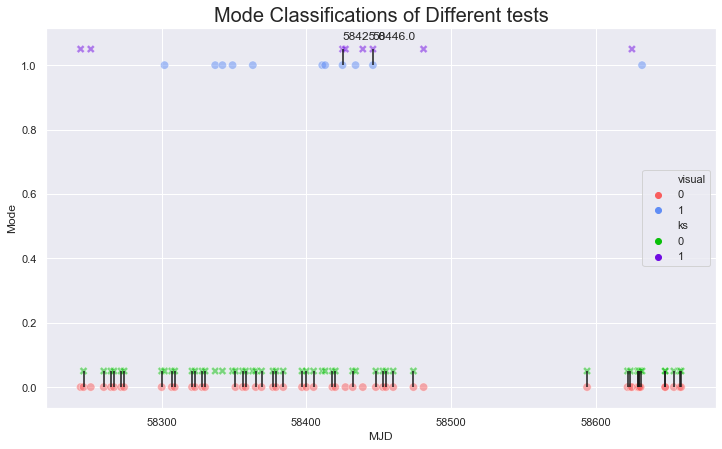

In [10]:
sns.set()
fig = plt.figure(figsize=(12,7))
cmap1 = sns.color_palette(['#F95E5E', '#608DF5'])
cmap2 = sns.color_palette(['#09C009', '#700BE2'])
ax = sns.scatterplot(x='mjd', y='visual', data=df, hue='visual', palette=cmap1, s=70, alpha=.5)
ax = sns.scatterplot(x='mjd', y='ks_offset', data=df, hue='ks',marker='X', palette=cmap2, s=70, alpha=.5)

#Display vlines for matching MJD, and display MJD value for abnormals
for i in df.index:
    if (df.match[i] == 1):
        x = df.mjd[i]
        y_lower = df.visual[i]
        y_higher = df.ks_offset[i]
        plt.vlines(x=x, ymin=y_lower, ymax=y_higher)
        if df.visual[i] == 1:
            plt.text(x, y_higher+.03, s=x)
            
ax.set_title('Mode Classifications of Different tests', fontdict={'fontsize':20})
ax.set_xlabel('MJD')
ax.set_ylabel('Mode')
plt.legend(loc='center right')
plt.savefig('./plots/test_comp.jpeg')